# Imports

In [31]:
import pandas as pd; import seaborn as sb; import statsmodels.formula.api as smf; import pingouin
#from statannot import add_stat_annotation; 
from itertools import combinations; import os;
from analysis_helpers import *; import scipy; from scipy import stats; import os; import math;
import warnings
warnings.filterwarnings('ignore')

# Load sample behavioral data

In [41]:
sub_list = []
data_dir = '/Users/kirstenziman/Desktop/FINAL_EYE_2019_Sep_05'

for sub_dir in os.listdir(data_dir):
    sub_list.append(add_level(sum_pd(data_dir + '/' + sub_dir)))
    print(sub_dir)
    
exp_raw = pd.concat(sub_list)
#exp1_raw.to_csv('../parsed_data/behavioral_data_sustained.csv')

test_data


# Load sample gaze data

In [42]:
# load gaze data
gaze = pd.read_csv('test_gaze.csv')

# Tendency to gaze towards cued side

In [47]:
gaze_grp_list = []

for data,behav,label in zip([gaze],[exp_raw[exp_raw['Trial Type']=='Presentation']],['test']):
    
    # Make sure behavioral data trials are numbered
    #behav.loc[behav['Trial Type']=='Memory','Trial'] = list(range(0,40))*1
    behav.loc[behav['Trial Type']=='Presentation','Trial'] = list(range(0,10))*1
    
    # group gaze data
    gaze_grp = data.groupby(['Subject','Run','Trial'], as_index=False).mean()
    gaze_grp['Run'] = pd.to_numeric(gaze_grp['Run'])
    gaze_grp_list.append(gaze_grp)
    
    # add av x coord to each presentation trial in behavioral df
    for s in gaze_grp['Subject'].unique():

        # special case for subject 327 (three digit subject #, as opposed to 2 digit)
        if label=='2' and s == 32:
            for r in gaze_grp[gaze_grp['Subject']==s]['Run'].unique():
                for t in gaze_grp[(gaze_grp['Subject']==s) & (gaze_grp['Run']==r)]['Trial'].unique():

                    if gaze_grp[(gaze_grp['Subject']==s) & (gaze_grp['Run']==r) & (gaze_grp['Trial']==t)].shape[0]>0:

                        behav.loc[(behav['Subject']==327) 
                                     & (behav['Run']==r) 
                                     & (behav['Trial']==t), 'av_x_coord'] =  gaze_grp[(gaze_grp['Subject']==s) 
                                                                                     & (gaze_grp['Run']==r) 
                                                                                     & (gaze_grp['Trial']==t)]['av_x_coord'].item()

        # all others have two digit subject number
        else:
            for r in gaze_grp[gaze_grp['Subject']==s]['Run'].unique():
                for t in gaze_grp[(gaze_grp['Subject']==s) & (gaze_grp['Run']==r)]['Trial'].unique():

                    if gaze_grp[(gaze_grp['Subject']==s) & (gaze_grp['Run']==r) & (gaze_grp['Trial']==t)].shape[0]>0:

                        behav.loc[(behav['Subject']==s) 
                                     & (behav['Run']==r) 
                                     & (behav['Trial']==t), 'av_x_coord'] =  gaze_grp[(gaze_grp['Subject']==s) 
                                                                                     & (gaze_grp['Run']==r) 
                                                                                     & (gaze_grp['Trial']==t)]['av_x_coord'].item()

    # compute av x gaze's difference from screen center
    behav['gaze_from_center'] = behav['av_x_coord'] - 59.8/2
    
    # make the difference value negative for opposite facing arrow
    behav['gaze_towards_cued_side'] = behav['gaze_from_center']
    behav.loc[(behav['Cued Side']=='<'),'gaze_towards_cued_side'] = -behav.loc[(behav['Cued Side']=='<')]['gaze_towards_cued_side']
    
    # ttest relative to zero drift! 
    behav_grp = behav.groupby(['Subject'], as_index=False).mean()
    print(scipy.stats.ttest_1samp(behav_grp['gaze_towards_cued_side'],0))
    print(np.mean(behav_grp['gaze_towards_cued_side'])/np.std(behav_grp['gaze_towards_cued_side']))

Ttest_1sampResult(statistic=nan, pvalue=nan)
inf


In [52]:
scipy.stats.ttest_1samp(behav['gaze_towards_cued_side'],0)

Ttest_1sampResult(statistic=26.132699016681265, pvalue=8.490809688271069e-10)

In [53]:
#scipy.stats.ttest_1samp(behav_grp['gaze_towards_cued_side'],0)

# Data restricted to gaze between images

In [58]:
restricted_concat = {}
for gaze,label in zip([gaze],['test']):

    gaze['gaze_from_center'] = gaze['av_x_coord'] - (59.8/2)
    
    gaze_restricted = gaze[abs(gaze['gaze_from_center'])<4.2752]
    gaze_restricted = gaze_restricted.groupby(['Subject','Run','Trial'], as_index=False).mean()
    
    restricted_behavioral = []

    for s in gaze_restricted['Subject'].unique():
        for r in gaze_restricted[gaze_restricted['Subject']==s]['Run'].unique():
            for t in gaze_restricted[(gaze_restricted['Subject']==s) & (gaze_restricted['Run']==r)]['Trial'].unique():
                restricted_behavioral.append(exp1[(exp1['Subject']==s) & (exp1['Run']==int(r)) & (exp1['Trial']==float(t))])
    
    restricted_concat[label] = pd.concat(restricted_behavioral)

In [59]:
restricted_concat

{'test': Empty DataFrame
 Columns: [Unnamed: 0, Unnamed: 0.1, Subject, Trial Type, Run, Cued Composite, Uncued Composite, Cued Face, Cued Place, Uncued Face, Uncued Place, Memory Image, Category, Cued Side, Cued Category, Attention Reaction Time (s), Familiarity Reaction Time (s), Familiarity Rating, Attention Level, Cue Validity, Post Invalid Cue, Pre Invalid Cue, Attention Button, Rating History, Stimulus Onset, Stimulus End, Attention Probe, Trial]
 Index: []
 
 [0 rows x 28 columns]}

# Attended Category vs Unattended Images

In [61]:
for l in restricted_concat:
    d = restricted_concat[l]

    Cats = []
    Novs = []
    for s in d['Subject'].unique():

        Cats.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Category','Full']))]['Familiarity Rating'].mean())
        Novs.append(d[(d['Subject']==s) & (d['Attention Level']=='None')]['Familiarity Rating'].mean())

#     print(l)
#     print(scipy.stats.ttest_rel(Cats, Novs))
#     print(cohen_d(Cats, Novs))
#     print()

# Attended Side vs Unattended Images

In [ ]:
for l in restricted_concat.keys():
    d = restricted_concat[l]

    Sides = []
    Novs = []
    
    for s in d['Subject'].unique():

        Sides.append(d[(d['Subject']==s) & (d['Attention Level'].isin(['Full','Side']))]['Familiarity Rating'].mean())
        Novs.append(d[(d['Subject']==s) & (d['Attention Level']=='None')]['Familiarity Rating'].mean())


    print(scipy.stats.ttest_rel(Sides, Novs))
    print(cohen_d(Sides, Novs))
    print()

# Plot

In [62]:
gaze_added_mem_dict = {}
gaze_added_mem = []

for data,label in zip([exp_raw],['test']):
    print(label)

    for s in data['Subject'].unique():
        print(s)
        for r in data['Run'].unique():
            gaze_added_mem.append(add_gaze(data[(data['Subject']==s) & (data['Run']==r)]))

    gaze_mem = pd.concat(gaze_added_mem)
    gaze_mem.loc[gaze_mem['Attention Level']=='Novel','av_x_coord']=0

    gaze_mem['gaze_towards'] = gaze_mem['av_x_coord'] - (59.8/2)

    gaze_mem.loc[(gaze_mem['Cued Side']=='<') 
                 & (gaze_mem['Attention Level'].isin(['Full', 'Side'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='<') 
                                                                                                          & (gaze_mem['Attention Level'].isin(['Full', 'Side']))]['gaze_towards']

    gaze_mem.loc[(gaze_mem['Cued Side']=='>') 
                 & (gaze_mem['Attention Level'].isin(['None', 'Category'])), 'gaze_towards'] = -gaze_mem[(gaze_mem['Cued Side']=='>') & (gaze_mem['Attention Level'].isin(['None', 'Category']))]['gaze_towards']

    gaze_mem_grp = gaze_mem.groupby(['Subject','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    gaze_added_mem_dict[label] = gaze_mem

test
FINAL_EYE


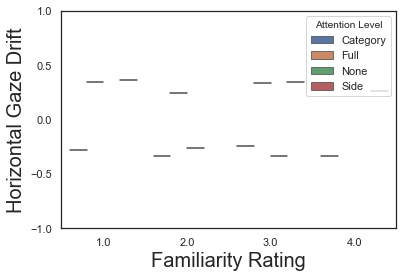

In [64]:
%matplotlib inline
for label in ['test']:
    
    gaze_mem_grp = gaze_added_mem_dict[label].groupby(['Subject','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    # scale by screen size
    gaze_mem_grp['scaled_gaze_towards'] = gaze_mem_grp['gaze_towards']/(59.8/2)

    # plot
    sb.set_style('white')

    f = sb.violinplot(x='Familiarity Rating', y='scaled_gaze_towards', 
                  data=gaze_mem_grp[gaze_mem_grp['Attention Level']!='Novel'], hue='Attention Level')

    plt.grid(False)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.xlabel('Familiarity Rating',    fontsize = 20)
    plt.ylabel('Horizontal Gaze Drift', fontsize = 20)
    f.set(ylim=(-1, 1))
    plt.show()


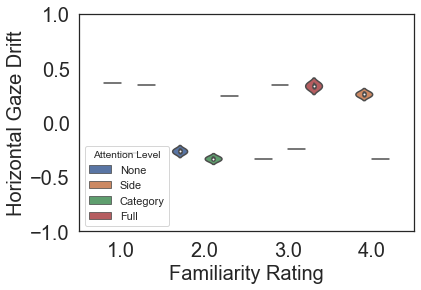

In [65]:
%matplotlib inline
for label in ['test']:
    
    gaze_mem_grp = gaze_added_mem_dict[label]#.groupby(['Subject','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    # scale by screen size
    gaze_mem_grp['scaled_gaze_towards'] = gaze_mem_grp['gaze_towards']/(59.8/2)

    # plot
    sb.set_style('white')

    f = sb.violinplot(x='Familiarity Rating', y='scaled_gaze_towards', 
                  data=gaze_mem_grp[gaze_mem_grp['Attention Level']!='Novel'], hue='Attention Level')

    plt.grid(False)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.xlabel('Familiarity Rating',    fontsize = 20)
    plt.ylabel('Horizontal Gaze Drift', fontsize = 20)
    f.set(ylim=(-1, 1))
    plt.show()

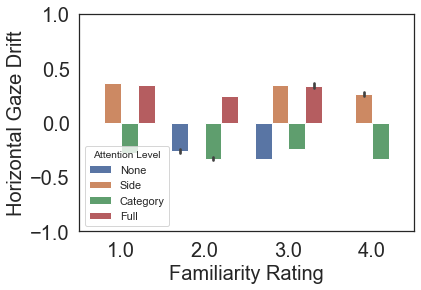

In [66]:
%matplotlib inline
for label in ['test']:
    
    gaze_mem_grp = gaze_added_mem_dict[label]#.groupby(['Subject','Attention Level', 'Familiarity Rating','Trial Type'], as_index=False).mean()

    # scale by screen size
    gaze_mem_grp['scaled_gaze_towards'] = gaze_mem_grp['gaze_towards']/(59.8/2)

    # plot
    sb.set_style('white')

    f = sb.barplot(x='Familiarity Rating', y='scaled_gaze_towards', 
                  data=gaze_mem_grp[gaze_mem_grp['Attention Level']!='Novel'], hue='Attention Level')

    plt.grid(False)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.xlabel('Familiarity Rating',    fontsize = 20)
    plt.ylabel('Horizontal Gaze Drift', fontsize = 20)
    f.set(ylim=(-1, 1))
    plt.show()